# Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# Loading data

In [2]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'valid-org-img', valid_dir/'valid-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [3]:
# Fetching all the jpgs from the img folder
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 0, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

In [4]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 25
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

data/FloodNet-Supervised_v1.0/train/train-org-img/8970.jpg
data/FloodNet-Supervised_v1.0/train/train-label-img/8970_lab.png


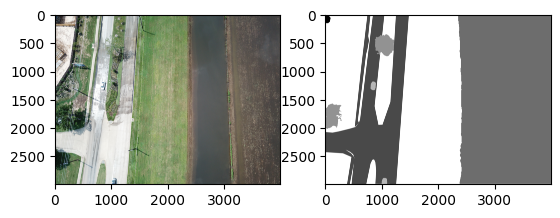

In [5]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [6]:
unique_labels = []
for img in tqdm(train_images):
    mask_path = label_mask_path(train_mask_dir, img)
    mask = np.asarray(Image.open(mask_path))
    unique_label = np.unique(mask).tolist()
    unique_labels.extend(unique_label)
print(f"No of unique labels: {len(set(unique_labels))}")

100%|██████████| 1445/1445 [03:48<00:00,  6.31it/s]

No of unique labels: 10


In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, images, transforms = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        current_img_path = self.images[idx]
        current_label_path = self.label_mask_path(current_img_path)
        img = np.asarray(Image.open(current_img_path)).copy()
        mask = np.asarray(Image.open(current_label_path)).copy()
        if self.transforms:
            transformed = self.transforms(image = img, mask = mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

    def label_mask_path(self, image_path):
        return self.masks_dir/f'{image_path.stem}_lab.png'

In [8]:
train_augmentation = A.Compose([# A.LongestMaxSize(max_size=1024, interpolation=1),
                                A.RandomCrop(height = 512, width = 512),
                                ToTensorV2(),
                                ])
train_dataset = SatelliteDataset(train_img_dir, train_mask_dir, train_images, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers=8)

In [9]:
imgs, masks = next(iter(trainloader))
imgs.shape, masks.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

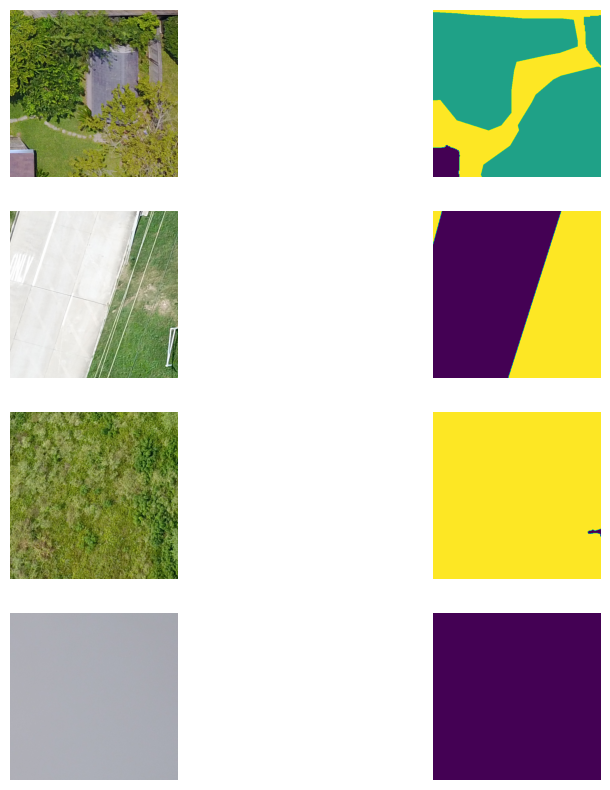

In [10]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    img, mask = np.transpose(imgs[i].cpu().detach(), (1,2,0)), masks[i]
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    axes[i, 1].axis('off')